In [ ]:
!sudo apt install tesseract-ocr
!pip install transformers datasets pytesseract donut-python

# OCR with Tesseract

https://nanonets.com/blog/ocr-with-tesseract/

 

Tesseract sample

{'level': [1, 2, 3, 4, 5, 5], 'page_num': [1, 1, 1, 1, 1, 1], 'block_num': [0, 1, 1, 1, 1, 1], 'par_num': [0, 0, 1, 1, 1, 1], 'line_num': [0, 0, 0, 1, 1, 1], 'word_num': [0, 0, 0, 0, 1, 2], 'left': [0, 57, 57, 57, 57, 350], 'top': [0, 130, 130, 130, 130, 130], 'width': [613, 498, 498, 498, 272, 205], 'height': [308, 60, 60, 60, 48, 60], 'conf': [-1, -1, -1, -1, 96, 96], 'text': ['', '', '', '', 'Tesseract', 'sample']}


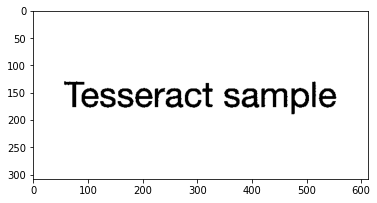

In [90]:
from PIL import Image
import pytesseract
import numpy as np
import cv2
from matplotlib.pyplot import imshow

image_path = 'https://miro.medium.com/max/613/0*9TvducuMQReSm0Rr.png'
img1 = Image.open(requests.get(image_path, stream=True).raw)
imshow(img1)
img_arr = np.array(img1)

# normalized & denoise image
norm_img = np.zeros((img_arr.shape[0], img_arr.shape[1]))
img = cv2.normalize(img_arr, norm_img, 0, 255, cv2.NORM_MINMAX)
img = cv2.threshold(img, 100, 255, cv2.THRESH_BINARY)[1]
img = cv2.GaussianBlur(img, (1, 1), 0)
imshow(img)

# couldn't detect image with noise
print(pytesseract.image_to_string(np.array(img1)))
print(pytesseract.image_to_string(np.array(img)))

# save metadata for plotting
results = pytesseract.image_to_data(img, output_type=pytesseract.Output.DICT)
print(results)

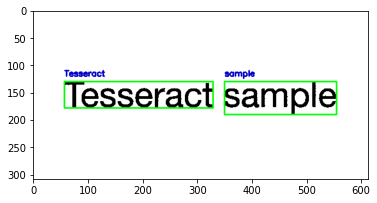

In [91]:
for i in range(0, len(results['text'])):

    # extract meta result
    x = results['left'][i]
    y = results['top'][i]
    w = results['width'][i]
    h = results['height'][i]
    text = results['text'][i]
    conf = int(results['conf'][i])

    # only plot if confidence greater than 70
    if conf > 70:

        # remove non-english word
        text = "".join([c if ord(c) < 128 else "" for c in text]).strip()
        cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)
        cv2.putText(img, text, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 200), 2)

imshow(img)

# TrOCR

require OCR to detect location and crop image

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-printed and are newly initialized: ['encoder.pooler.dense.weight', 'encoder.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


torch.Size([1, 3, 384, 384])
tensor([[    2, 13796,   574,  3048,  1941,     2]])
torch.Size([1, 6])
['INDLUS THE']


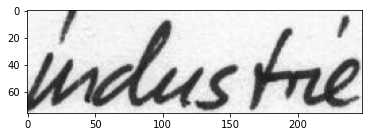

In [99]:
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
from PIL import Image
import requests

# load image from the IAM database (actually this model is meant to be used on printed text)
url = 'https://fki.tic.heia-fr.ch/static/img/a01-122-02-00.jpg'
image = Image.open(requests.get(url, stream=True).raw).convert("RGB")
processor = TrOCRProcessor.from_pretrained('microsoft/trocr-base-printed')
model = VisionEncoderDecoderModel.from_pretrained('microsoft/trocr-base-printed')

# generate embedding of images
pixel_values = processor(images=image, return_tensors="pt").pixel_values
print(pixel_values.size())

generated_ids = model.generate(pixel_values)
print(generated_ids)
print(generated_ids.size())

generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)

imshow(image)
print(generated_text)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['SAMPLE']


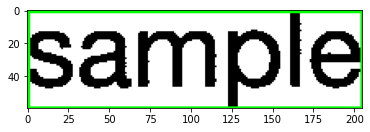

In [100]:
# cropped image
crop_img = img[y:y+h, x:x+w]
imshow(crop_img)

# generate embedding of images
pixel_values = processor(images=crop_img, return_tensors="pt").pixel_values
generated_ids = model.generate(pixel_values)

generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)
print(generated_text)

# LayoutMv3

Requires Tesseract OCR engine to turn the image into a list of recognized words.
Mainly used for classification,  [Bill, Invoce, Purchase_Order]

https://lucky-verma.medium.com/document-classification-using-layoutlm-8f3cfd8389d1

https://huggingface.co/docs/transformers/model_doc/layoutlmv3#transformers.LayoutLMv3ForSequenceClassification

In [36]:
from transformers import AutoProcessor, AutoModelForSequenceClassification
from datasets import load_dataset
import torch

processor = AutoProcessor.from_pretrained("microsoft/layoutlmv3-base", apply_ocr=False)
model = AutoModelForSequenceClassification.from_pretrained("microsoft/layoutlmv3-base")

dataset = load_dataset("nielsr/funsd-layoutlmv3", split="train")
example = dataset[0]
image = example["image"]
words = example["tokens"]
boxes = example["bboxes"]

print(len(words))
print(len(boxes))

encoding = processor(image, words, boxes=boxes, return_tensors="pt")
print(encoding.keys())

outputs = model(**encoding, labels=torch.tensor([1]))
loss = outputs.loss
logits = outputs.logits
print(loss)
print(logits.size())

Some weights of LayoutLMv3ForSequenceClassification were not initialized from the model checkpoint at microsoft/layoutlmv3-base and are newly initialized: ['classifier.out_proj.weight', 'classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.7/dist-packages/transformers/modeling_utils.py:714: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  "The `device` argument is deprecated and will be removed in v5 of Transformers.", FutureWarning


145
145
dict_keys(['input_ids', 'attention_mask', 'bbox', 'pixel_values'])
tensor(0.8650, grad_fn=<NllLossBackward0>)
torch.Size([1, 2])


# OCR-Free Document Understanding (Donut)

https://huggingface.co/docs/transformers/main/en/model_doc/donut

In [110]:
import re
from transformers import DonutProcessor, VisionEncoderDecoderModel
from datasets import load_dataset
import torch
from matplotlib.pyplot import imshow

ImportError: ignored

In [108]:
### document classification
processor = DonutProcessor.from_pretrained("naver-clova-ix/donut-base-finetuned-rvlcdip")
model = VisionEncoderDecoderModel.from_pretrained("naver-clova-ix/donut-base-finetuned-rvlcdip")

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

# load document image
dataset = load_dataset("hf-internal-testing/example-documents", split="test")
image = dataset[1]["image"]


# prepare decoder inputs
task_prompt = "<s_rvlcdip>"
decoder_input_ids = processor.tokenizer(task_prompt, add_special_tokens=False, return_tensors="pt").input_ids

pixel_values = processor(image, return_tensors="pt").pixel_values

outputs = model.generate(
    pixel_values.to(device),
    decoder_input_ids=decoder_input_ids.to(device),
    max_length=model.decoder.config.max_position_embeddings,
    early_stopping=True,
    pad_token_id=processor.tokenizer.pad_token_id,
    eos_token_id=processor.tokenizer.eos_token_id,
    use_cache=True,
    num_beams=1,
    bad_words_ids=[[processor.tokenizer.unk_token_id]],
    return_dict_in_generate=True,
)

sequence = processor.batch_decode(outputs.sequences)[0]
sequence = sequence.replace(processor.tokenizer.eos_token, "").replace(processor.tokenizer.pad_token, "")
sequence = re.sub(r"<.*?>", "", sequence, count=1).strip()  # remove first task start token
print(processor.token2json(sequence))
{'class': 'advertisement'}

AttributeError: ignored